Tools used: 
- sra-tools https://github.com/ncbi/sra-tools 
- seqtk https://github.com/lh3/seqtk
- awk https://github.com/onetrueawk/awk
- colord (original) https://github.com/refresh-bio/CoLoRd ; compiled with `MEASURE_THREADS_TIMES` defined
- pandas, seqborn, matplotlib, tqdm... 

In [1]:
import os
import time
import gzip
import shutil

import numpy as np
import subprocess as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict, defaultdict
from tqdm import tqdm
from pprint import pprint

from IPython.display import display

sns.set(style='whitegrid', font_scale=1.2)
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100

# Data

---

### Human chromosome 1 and MGISEQ2000 sequence data with 30x coverage

#### Reference Statistics:

| Length    | Id           | Description                                                                    |
|-----------|--------------|--------------------------------------------------------------------------------|
| 248956422 | NC_000001.11 | Homo sapiens chromosome 1                                                      |
| 175055    | NT_187361.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG1_UNLOCALIZED |
| 32032     | NT_187362.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG2_UNLOCALIZED |
| 127682    | NT_187363.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG3_UNLOCALIZED |
| 66860     | NT_187364.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG4_UNLOCALIZED |
| 40176     | NT_187365.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG5_UNLOCALIZED |
| 42210     | NT_187366.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG6_UNLOCALIZED |
| 176043    | NT_187367.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG7_UNLOCALIZED |
| 40745     | NT_187368.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG8_UNLOCALIZED |
| 41717     | NT_187369.1  | Homo sapiens chromosome 1 unlocalized genomic scaffold HSCHR1_CTG9_UNLOCALIZED |


In [2]:
data_folder = 'data/'
compress_mode = 'pbraw'
data_title = f'Human chromosome 1, MGISEQ2000, colord compress-{compress_mode}'
chart_prefix = f'charts/hg/compress-{compress_mode}/mgiseq_'
cov_to_check = 2. ** np.arange(-4, 5)
fastq_filepath = data_folder + 'MGISEQ2000__HG004_sub30_q4.chr1.fq'
reference_filepath = data_folder + 'hg38.chr1.fna'

cov_to_check

array([ 0.0625,  0.125 ,  0.25  ,  0.5   ,  1.    ,  2.    ,  4.    ,
        8.    , 16.    ])

## Calculate Coverage

In [3]:
def calculate_coverage(filename, genome_size = 248_387_328):
    cmd = ['awk', '"{if(NR%4==2) {bases += length} } END{print bases}"', filename]
    p = sp.run(' '.join(cmd), shell=True, capture_output=True)
    
    return int(p.stdout.decode('utf8')) / genome_size

ori_cov = calculate_coverage(fastq_filepath)
fastq_filepath, ori_cov

('data/MGISEQ2000__HG004_sub30_q4.chr1.fq', 29.75359334756401)

## Subsample `.fastq` file

In [4]:
SEED = 42

fractions = [round(cov / ori_cov, 4) for cov in cov_to_check]
filenames = []

for cov, fr in tqdm(zip(cov_to_check, fractions)):
    fn = fastq_filepath.replace('.fq', f'-subs-cov-{cov}.fq').replace('.0.', '.')
    
    if not os.path.isfile(fn):
        cmd = f"seqtk seq -f {fr} -s {SEED} {fastq_filepath} > {fn}"
        sp.run(cmd, check=True, shell=True)
    
    filenames.append(fn)
    
filenames.append(fastq_filepath)
cov_to_check = np.append(cov_to_check, 29.7)

9it [00:00, 51150.05it/s]


## Calculate coverage

In [5]:
coverages = [calculate_coverage(f) for f in tqdm(filenames)]

for f, c in zip(filenames, coverages): 
    print(f, c)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:20<00:00, 14.06s/it]

data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.0625.fq 0.0625702209735917
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.125.fq 0.12520385097906445
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.25.fq 0.25007555941018056
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.5.fq 0.49958768427993233
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-1.fq 0.999730952458251
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-2.fq 1.999483645156004
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-4.fq 3.9992668225007035
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-8.fq 7.99849620347782
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-16.fq 15.999985313260424
data/MGISEQ2000__HG004_sub30_q4.chr1.fq 29.75359334756401


...close enough ;)

## Run `CoLoRd` for all files

In [6]:
logs, logs_r = [], []
CLRD="../colord/bin/colord"

# fastq
for inp in tqdm(filenames):
    # without reference
    out = inp.removesuffix('.fq') + '.' + compress_mode + '-default'
    log = inp.removesuffix('.fq') + '.' + compress_mode + '-default.log'
    
    logs.append(log)
    if not os.path.isfile(log):
        cmd = [CLRD, 'compress-' + compress_mode, inp, out, '--verbose', '--threads', '8', '2>', log]
        cmd = ' '.join(cmd)
        
        print(cmd)
        pr = sp.run(cmd, shell=True, capture_output=True, check=True)
        
    # with reference
    out = inp.removesuffix('.fq') + '.' + compress_mode + '-default-ref'
    log = inp.removesuffix('.fq') + '.' + compress_mode + '-default-ref.log'
    
    logs_r.append(log)
    if not os.path.isfile(log):
        cmd = [CLRD, 'compress-' + compress_mode, inp, out, '--verbose', '--threads', '8',
               '--reference-genome', reference_filepath, '2>', log]
        cmd = ' '.join(cmd)
        
        print(cmd)
        pr = sp.run(cmd, shell=True, capture_output=True, check=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34692.34it/s]


## Calculate CR

In [7]:
def parse_log_file(log):
    def construct_dict_(lines):
        return dict(map(str.strip, line.split(':', 1)) for line in lines)
    
    with open(log) as f:
        # messy hack with \t and dict
        
        lines_tab, lines_no_tab = [], []
        for line in f:
            if ':' in line and line[0] != '#':
                (lines_no_tab, lines_tab)[line[0] == '\t'].append(line)
        
        return (construct_dict_(lines_no_tab), construct_dict_(lines_tab))

# calculating stats for every file
def calculate_cr_stats(filenames, logs):   
    stats = defaultdict(list)
    for inp, logfile, coverage in zip(filenames, logs, coverages):
        log, log_tab = parse_log_file(logfile)
        
        print(logfile)
        
        stats['Filename'].append(os.path.basename(inp))
        stats['Coverage'].append(coverage)
        
        stats['CR_dna']   .append(int(log_tab['DNA size'])    / int(log['DNA size']))
        stats['CR_qual']  .append(int(log_tab['DNA size'])    / int(log['Quality size']))      
        
    return stats
        
cr_stats = calculate_cr_stats(filenames, logs)
cr_stats_r = calculate_cr_stats(filenames, logs_r)

data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.0625.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.125.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.25.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.5.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-1.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-2.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-4.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-8.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-16.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1.pbraw-default.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.0625.pbraw-default-ref.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.125.pbraw-default-ref.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.25.pbraw-default-ref.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.5.pbraw-default-ref.log
data/MGISEQ2000__HG004_sub30_q4.chr1-subs-

In [8]:
df = pd.DataFrame.from_dict(cr_stats).set_index('Filename')
df['Reference'] = False

df_r = pd.DataFrame.from_dict(cr_stats_r).set_index('Filename')
df_r['Reference'] = True

df_cr = pd.concat([df, df_r])
df_cr

,Coverage,CR_dna,CR_qual,Reference
Filename,,,,
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.0625.fq,0.062570,4.501216,228553.676471,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.125.fq,0.125204,4.544744,242961.328125,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.25.fq,0.250076,4.580492,266590.557940,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.5.fq,0.499588,4.620122,265720.021413,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-1.fq,0.999731,4.714754,261115.141956,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-2.fq,1.999484,5.094900,259752.301255,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-4.fq,3.999267,6.311133,260248.153000,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-8.fq,7.998496,8.061781,260554.111475,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-16.fq,15.999985,9.200777,260483.292915,False


## Coverage vs CR Chart

In [9]:
df_long = pd.melt(df_cr, id_vars=['Coverage', 'Reference'], value_vars=['CR_dna', 'CR_qual'], var_name='Type', value_name='CR')
df_long['Type'] = [s[3:] for s in df_long['Type']]
df_long

,Coverage,Reference,Type,CR
0,0.062570,False,dna,4.501216
1,0.125204,False,dna,4.544744
2,0.250076,False,dna,4.580492
3,0.499588,False,dna,4.620122
4,0.999731,False,dna,4.714754
5,1.999484,False,dna,5.094900
6,3.999267,False,dna,6.311133
7,7.998496,False,dna,8.061781
8,15.999985,False,dna,9.200777
9,29.753593,False,dna,9.958569


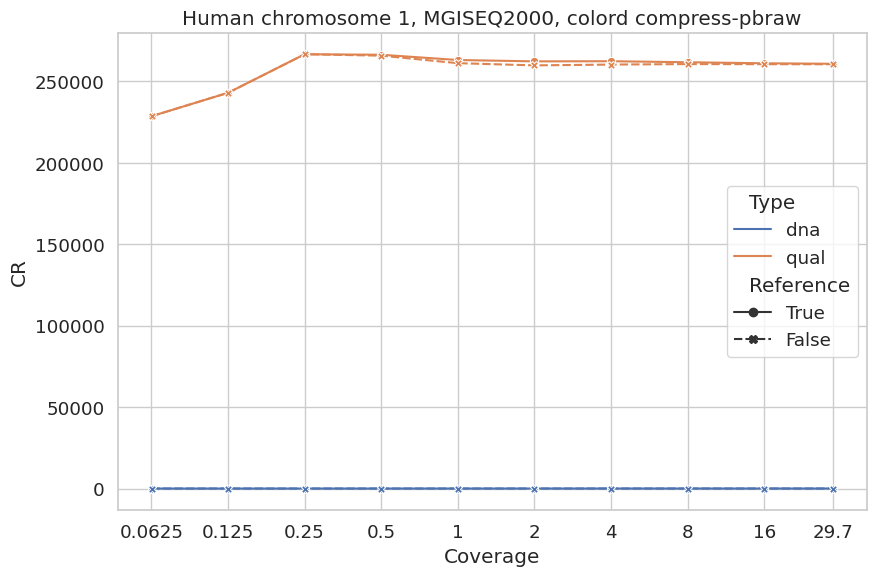

In [10]:
sns.lineplot(data=df_long, x='Coverage', y='CR', hue='Type', style='Reference', markers=True, style_order=[True, False])
plt.xscale('log')

plt.title(data_title)
plt.xticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
plt.tight_layout();
plt.savefig(chart_prefix + 'cr-vs-ref.pdf');

## Calculate Total Time

In [11]:
# calculating stats for every file
def calculate_time_stats(filenames, logs):   
    stats = defaultdict(list)
    for inp, logfile, coverage in zip(filenames, logs, coverages):
        log, log_tab = parse_log_file(logfile)
        
        stats['Filename'].append(os.path.basename(inp))
        stats['Coverage'].append(coverage)
        stats['Total time, s'].append(float(log['Total time'][:-1]))
        
    return stats
        
time_stats = calculate_time_stats(filenames, logs)
time_stats_r = calculate_time_stats(filenames, logs_r)

In [12]:
df = pd.DataFrame.from_dict(time_stats).set_index('Filename')
df['Reference'] = False

df_r = pd.DataFrame.from_dict(time_stats_r).set_index('Filename')
df_r['Reference'] = True

df_time = pd.concat([df, df_r])
df_time

,Coverage,"Total time, s",Reference
Filename,,,
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.0625.fq,0.062570,1.34696,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.125.fq,0.125204,2.05161,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.25.fq,0.250076,3.44189,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.5.fq,0.499588,6.74625,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-1.fq,0.999731,12.94820,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-2.fq,1.999484,28.07880,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-4.fq,3.999267,68.31950,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-8.fq,7.998496,191.94500,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-16.fq,15.999985,437.63600,False


## Coverage vs Time Chart

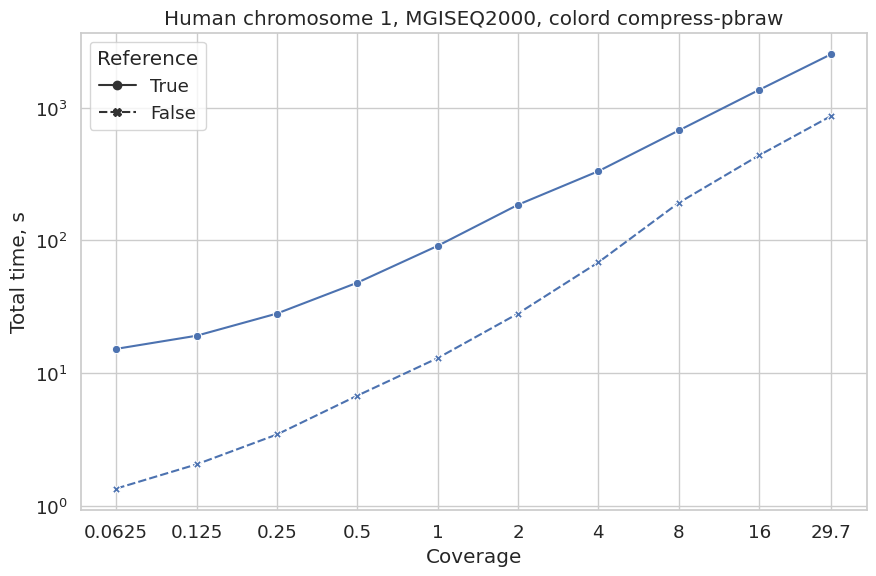

In [13]:
sns.lineplot(data=df_time, x='Coverage', y='Total time, s', style='Reference', markers=True, style_order=[True, False])
plt.xscale('log')
plt.yscale('log')

plt.title(data_title)
plt.xticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
# plt.yticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
plt.tight_layout();
plt.savefig(chart_prefix + 'time-vs-ref.pdf');

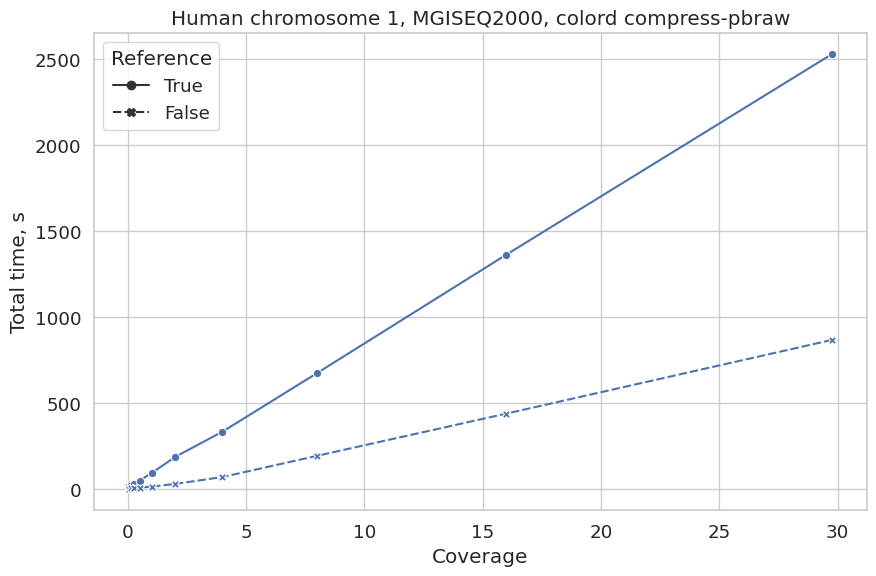

In [14]:
sns.lineplot(data=df_time, x='Coverage', y='Total time, s', style='Reference', markers=True, style_order=[True, False])

plt.title(data_title)
plt.tight_layout();
plt.savefig(chart_prefix + 'time-vs-ref-unlog.pdf');

## Calculate Threads Time

In [15]:
def collect_time_no_tab(log):
    # evene messier!
    with open(log) as f:
        return [float(line.removeprefix('Time: ').removesuffix('s\n'))
               for line in f if line.startswith("Time:")]

In [16]:
# calculating stats for every file
def calculate_threads_time_stats(filenames, logs):   
    stats = defaultdict(list)
    for inp, logfile, coverage in zip(filenames, logs, coverages):
        log, log_tab = parse_log_file(logfile)
        
        stats['Filename'].append(os.path.basename(inp))
        stats['Coverage'].append(coverage)
        
        times_no_tab = collect_time_no_tab(logfile)
        have_ref = len(times_no_tab) > 2
        
        time_io = float(log_tab['reader']) + \
                  float(log_tab['store result'])
            
        time_graph = sum(float(log_tab[col]) 
                         for col in ['similarity finder', 
                                     'mean similarity finder internal',
                                     'mean encoders',
                                     'mean encoders wait on queue']) + \
                    (times_no_tab[3] if have_ref else times_no_tab[0])
        
        time_coding = sum(float(log_tab[col]) 
                         for col in log_tab.keys() if col.startswith('entr. compr.'))
                     
        
        stats['Time - IO'].append(time_io)
        stats['Time - Sim.Graph'].append(time_graph)   
        stats['Time - RangeCoding'].append(time_coding)
        
    return stats
        
time_stats_th = calculate_threads_time_stats(filenames, logs)
time_stats_th_r = calculate_threads_time_stats(filenames, logs_r)

In [17]:
df = pd.DataFrame.from_dict(time_stats_th).set_index('Filename')
df['Reference'] = False

df_r = pd.DataFrame.from_dict(time_stats_th_r).set_index('Filename')
df_r['Reference'] = True

df_th_t = pd.concat([df, df_r])
df_th_t

,Coverage,Time - IO,Time - Sim.Graph,Time - RangeCoding,Reference
Filename,,,,,
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.0625.fq,0.062570,0.174393,0.441754,0.554060,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.125.fq,0.125204,0.409909,1.033796,1.115999,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.25.fq,0.250076,0.833674,2.409426,2.417257,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-0.5.fq,0.499588,1.803460,5.980766,5.129405,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-1.fq,0.999731,3.857029,15.160019,11.134115,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-2.fq,1.999484,7.879646,39.549903,23.403962,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-4.fq,3.999267,16.424377,97.097667,44.800828,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-8.fq,7.998496,37.095876,279.283420,91.520940,False
MGISEQ2000__HG004_sub30_q4.chr1-subs-cov-16.fq,15.999985,78.526088,578.412290,172.186860,False


## Coverage vs Thread Time

In [18]:
df_long = pd.melt(df_th_t, id_vars=['Coverage', 'Reference'], 
                  value_vars=['Time - IO', 'Time - Sim.Graph', 'Time - RangeCoding'], 
                  var_name='Thread', value_name='Time, s')

df_long['Thread'] = [s[7:] for s in df_long['Thread']]
df_long

,Coverage,Reference,Thread,"Time, s"
0,0.062570,False,IO,0.174393
1,0.125204,False,IO,0.409909
2,0.250076,False,IO,0.833674
3,0.499588,False,IO,1.803460
4,0.999731,False,IO,3.857029
5,1.999484,False,IO,7.879646
6,3.999267,False,IO,16.424377
7,7.998496,False,IO,37.095876
8,15.999985,False,IO,78.526088
9,29.753593,False,IO,150.491477


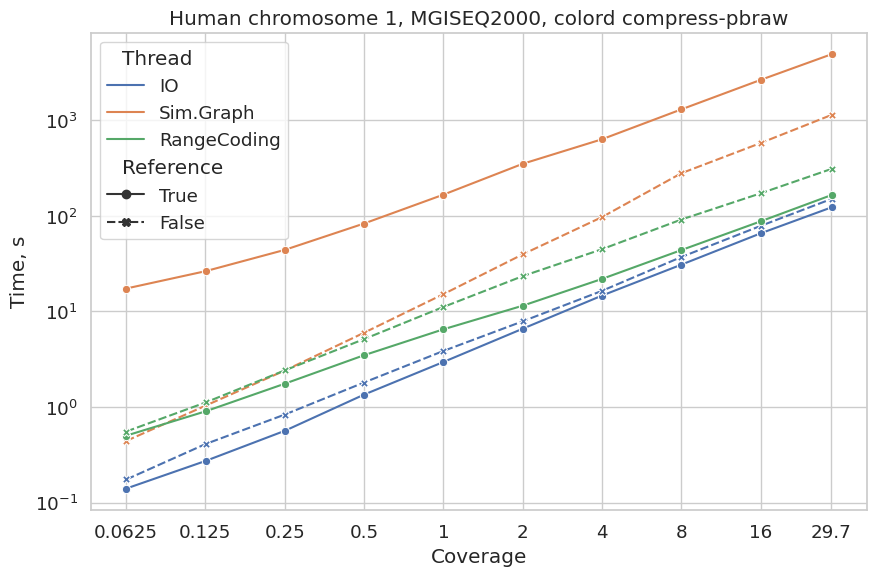

In [19]:
sns.lineplot(data=df_long, x='Coverage', y='Time, s', hue='Thread', style='Reference', markers=True, style_order=[True, False])
plt.xscale('log')
plt.yscale('log')

plt.title(data_title)
plt.xticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
plt.tight_layout();
plt.savefig(chart_prefix + 'thread-time-vs-ref.pdf');
# plt.savefig(chart_prefix + 'thread-time-vs-ref.png', dpi=300);


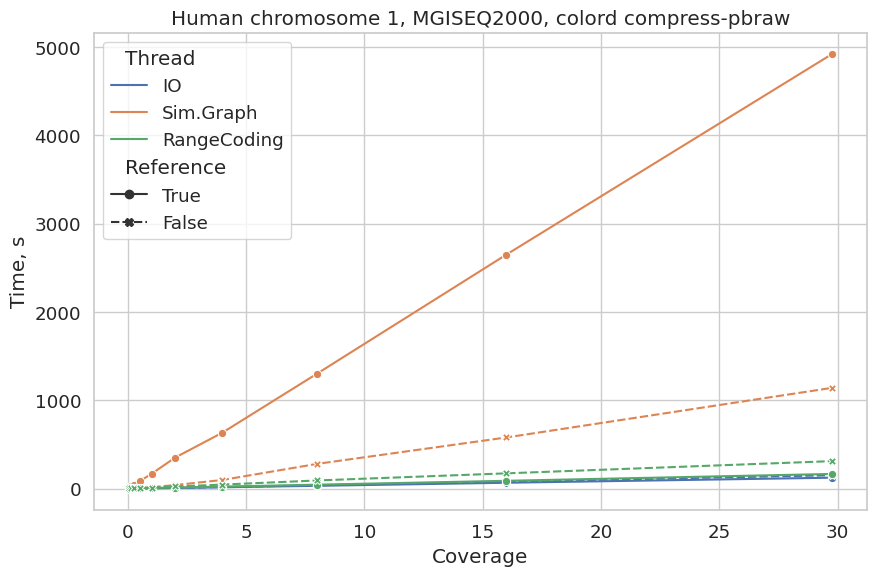

In [20]:
sns.lineplot(data=df_long, x='Coverage', y='Time, s', hue='Thread', style='Reference', markers=True, style_order=[True, False])
# plt.xscale('log')
# plt.yscale('log')

plt.title(data_title)
# plt.xticks(cov_to_check, [str(c).removesuffix('.0') for c in cov_to_check]);
plt.tight_layout();
plt.savefig(chart_prefix + 'thread-time-vs-ref-unlog.pdf');
# plt.savefig(chart_prefix + 'thread-time-vs-ref.png', dpi=300);
